In [1]:
#imports 
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T

from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from nltk.corpus import stopwords

from torchvision.models import resnet50, ResNet50_Weights
import torch
import datetime
import re
from tabulate import tabulate
from nltk.translate.bleu_score import sentence_bleu

import sys
sys.path.append('../src')
from utils import Vocabulary, FlickrDataset, CapsCollate, show_image, EncoderDecoder, DecoderRNN
from pylab import rcParams

image_path = "../all_images/Flicker8k_Dataset/" 
train_file_path = '../all_captions/Flickr_8k.trainImages.txt'
captions_path = "../all_captions/Flickr8k.token.txt"
test_file_path = '../all_captions/Flickr_8k.testImages.txt'

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def clean_text(text):
  text = text.lower()
  text = re.sub("[^a-z]+", " ", text)
  text = text.split()
  text = [s for s in text if len(s)> 1]
  text = " ".join(text)
  return text

caption_file = open(captions_path, "r").read()

BATCH_SIZE = 256
NUM_WORKERS = 0
frequency_threshold = 1

transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(),
                T.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
            )])

toTensor = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor()])

keys = []
caption_list = []

for row in caption_file.split("\n"):
    key = row.split("#")[0].split(".")[0]
    caption = row.split("#")[-1].split("\t")[-1]
    caption = caption.replace('.', '')
    caption = clean_text(caption)

    keys.append(key)
    caption_list.append(caption)

captions = pd.DataFrame(data=zip(keys, caption_list), columns=["image", "caption"])

train_file = open(train_file_path, 'r').read()
train_imgs = [row.split(".")[0] for row in train_file.split("\n")[:-1]]
train_data = captions[captions.image.isin(train_imgs)]
train_data = train_data.reset_index()

test_file = open(test_file_path, 'r').read()
test_imgs = [row.split(".")[0] for row in test_file.split("\n")[:-1]]
test_data = captions[captions.image.isin(test_imgs)]
test_data = test_data.reset_index()

vocab = Vocabulary(frequency_threshold)
vocab.build_vocab(captions.caption.tolist())

train_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", train_data, transform=transform, vocab=vocab)
test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", test_data, transform=toTensor, vocab=vocab)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=CapsCollate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#len of vocabulary
len(vocab)

8426

In [47]:
embed_size = 300
vocab_size = len(vocab)
attention_dim = 3000
encoder_dim = 2048
decoder_dim = 3000

model = EncoderDecoder(embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, device)
model.load_state_dict(torch.load("../models/resnet101-3000-attention-and-decoder-dimensions.pth", map_location=device))
model.eval()
model.to(device)

c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderDecoder(
  (encoder): EncoderCNN(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
 

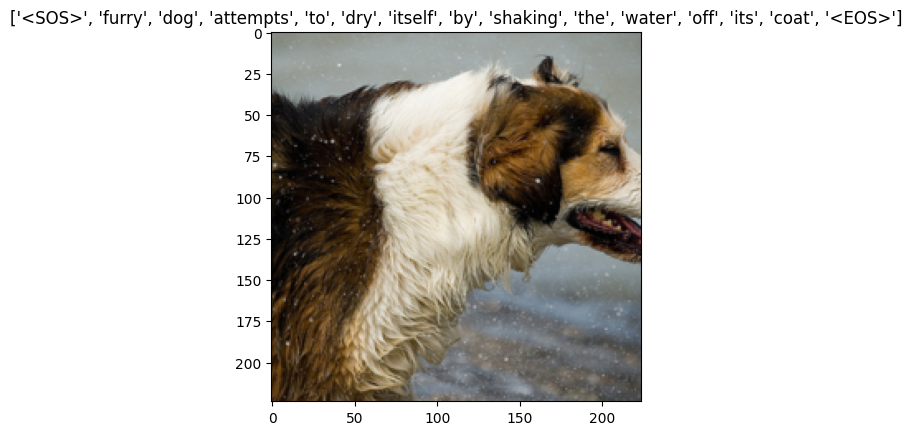

In [7]:
show_image(test_dataset[42][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]])

In [8]:
features = model.encoder(test_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)

In [9]:
len(alphas), caption

(8, ['white', 'dog', 'with', 'leash', 'running', 'in', 'water', '<EOS>'])

In [10]:
test_dataset[42][0].shape

torch.Size([3, 224, 224])

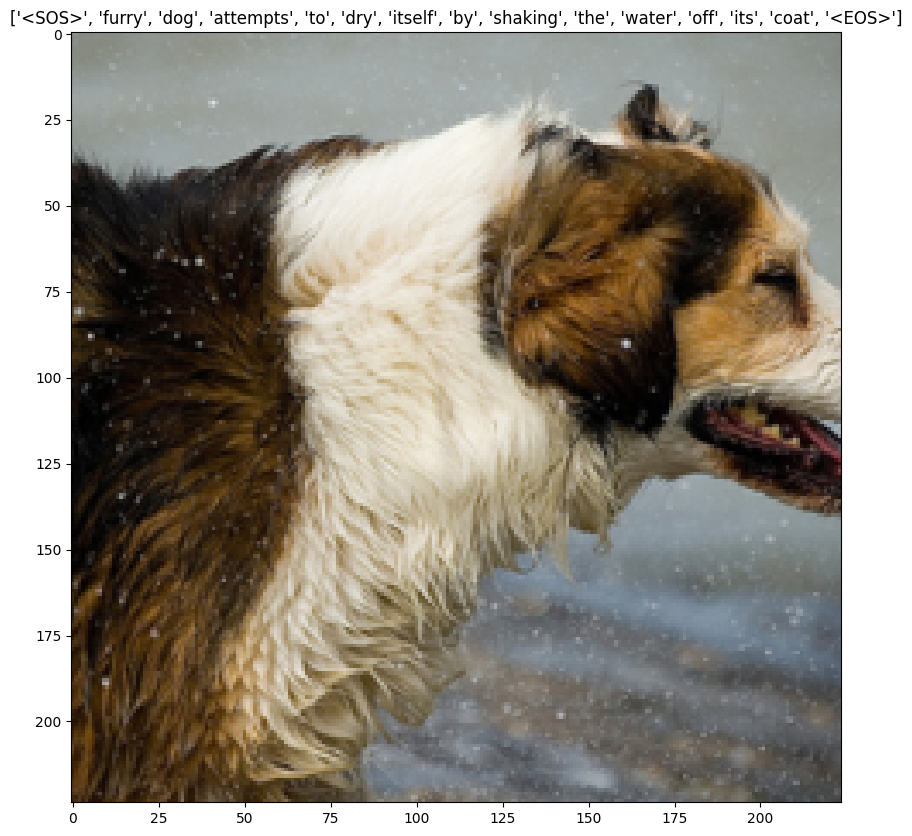

In [11]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[42][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]])

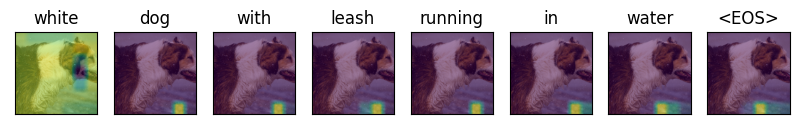

Original Caption:  <SOS> furry dog attempts to dry itself by shaking the water off its coat <EOS>


In [12]:
features = model.encoder(test_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[42][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 20, 40
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[42][1]]))

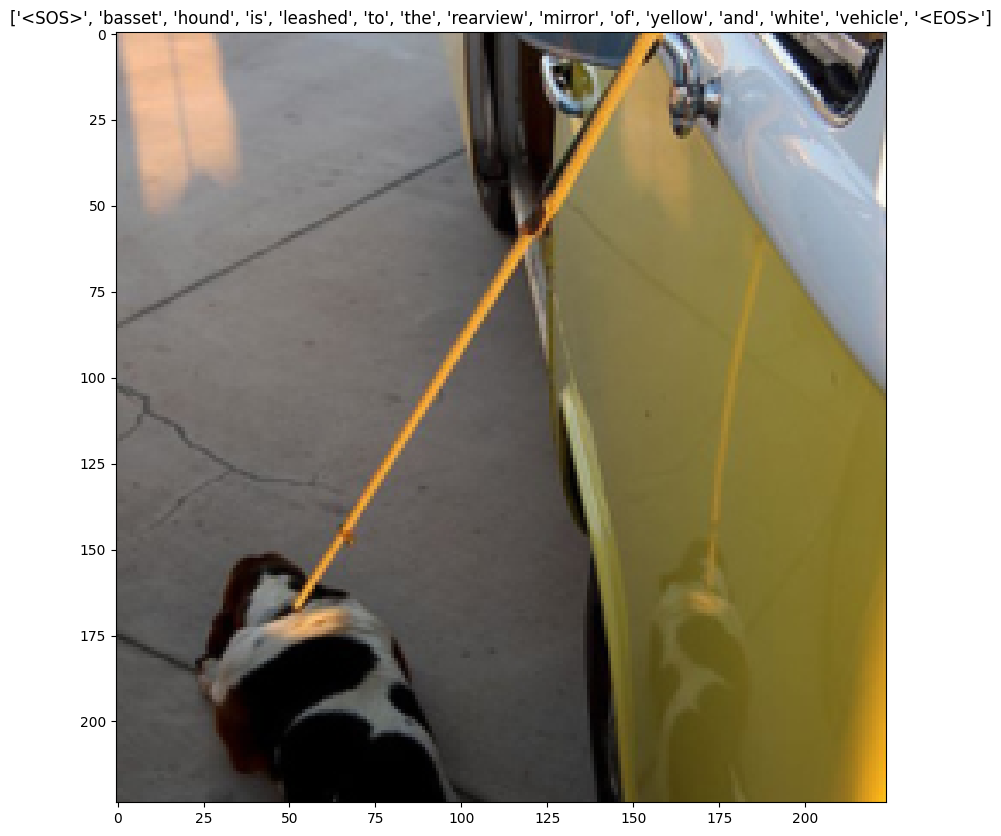

In [13]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[420][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[420][1]])

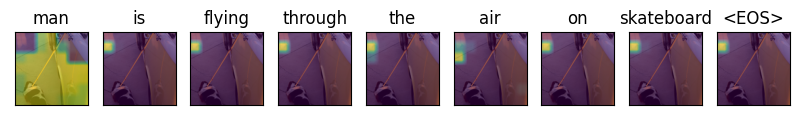

Original Caption:  <SOS> basset hound is leashed to the rearview mirror of yellow and white vehicle <EOS>


In [14]:
features = model.encoder(test_dataset[420][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[420][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 30, 30
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[420][1]]))

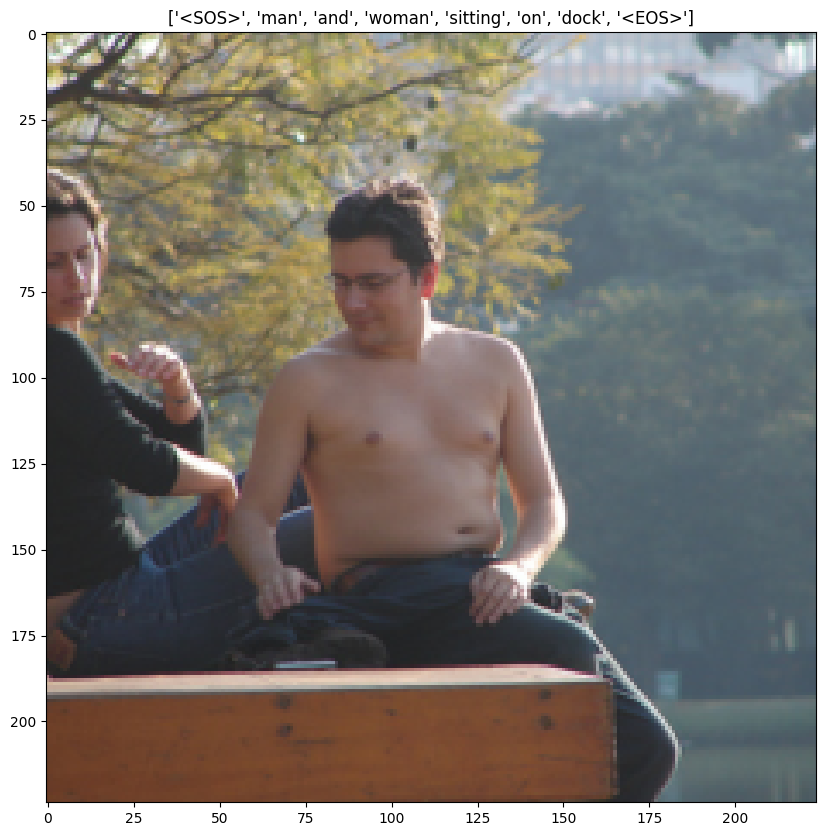

In [15]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[12][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[12][1]])

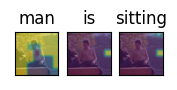

Original Caption:  <SOS> man and woman sitting on dock <EOS>
Generated Caption:  man is sitting on the edge of pool with his shoes in the air <EOS>


In [16]:
features = model.encoder(test_dataset[12][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas) - 12):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[12][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 50, 20
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[12][1]]))
print("Generated Caption: ", " ".join(caption))

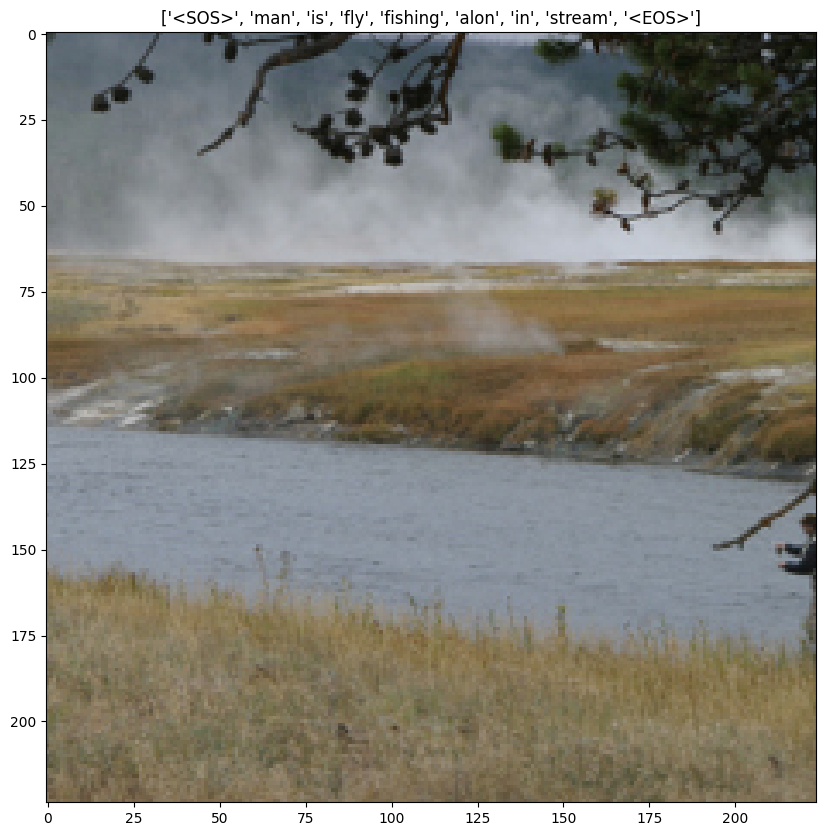

In [17]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[1230][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[1230][1]])

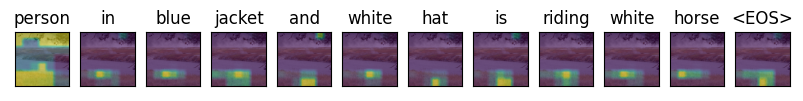

Original Caption:  <SOS> man is fly fishing alon in stream <EOS>
Generated Caption:  person in blue jacket and white hat is riding white horse <EOS>


In [18]:
features = model.encoder(test_dataset[1230][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[1230][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 50, 20
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[1230][1]]))
print("Generated Caption: ", " ".join(caption))

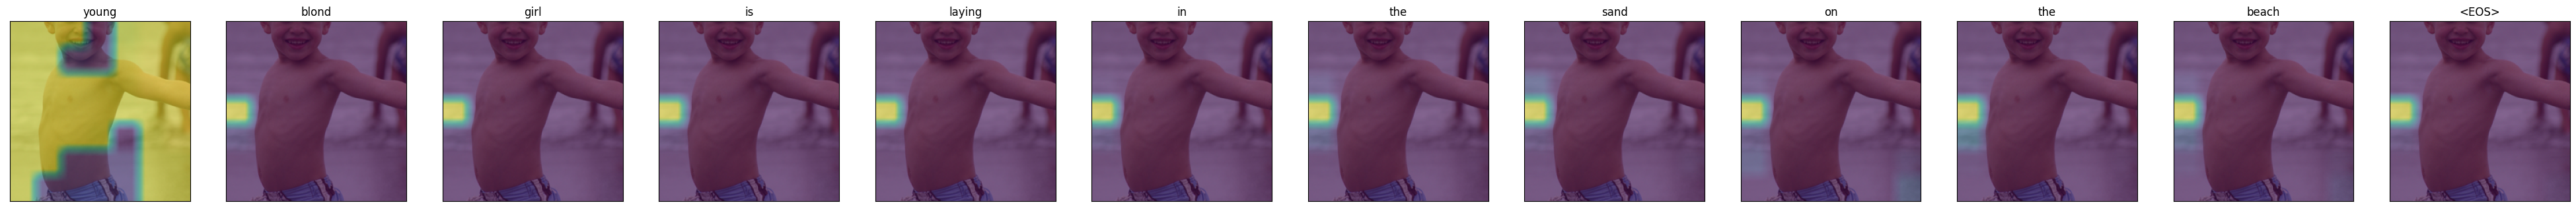

Original Caption:  <SOS> boy in his blue swim shorts at the beach <EOS>
Generated Caption:  young blond girl is laying in the sand on the beach <EOS>


In [19]:
features = model.encoder(test_dataset[5][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(test_dataset[5][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 50, 10
plt.show()

print("Original Caption: ", " ".join([test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[5][1]]))
print("Generated Caption: ", " ".join(caption))

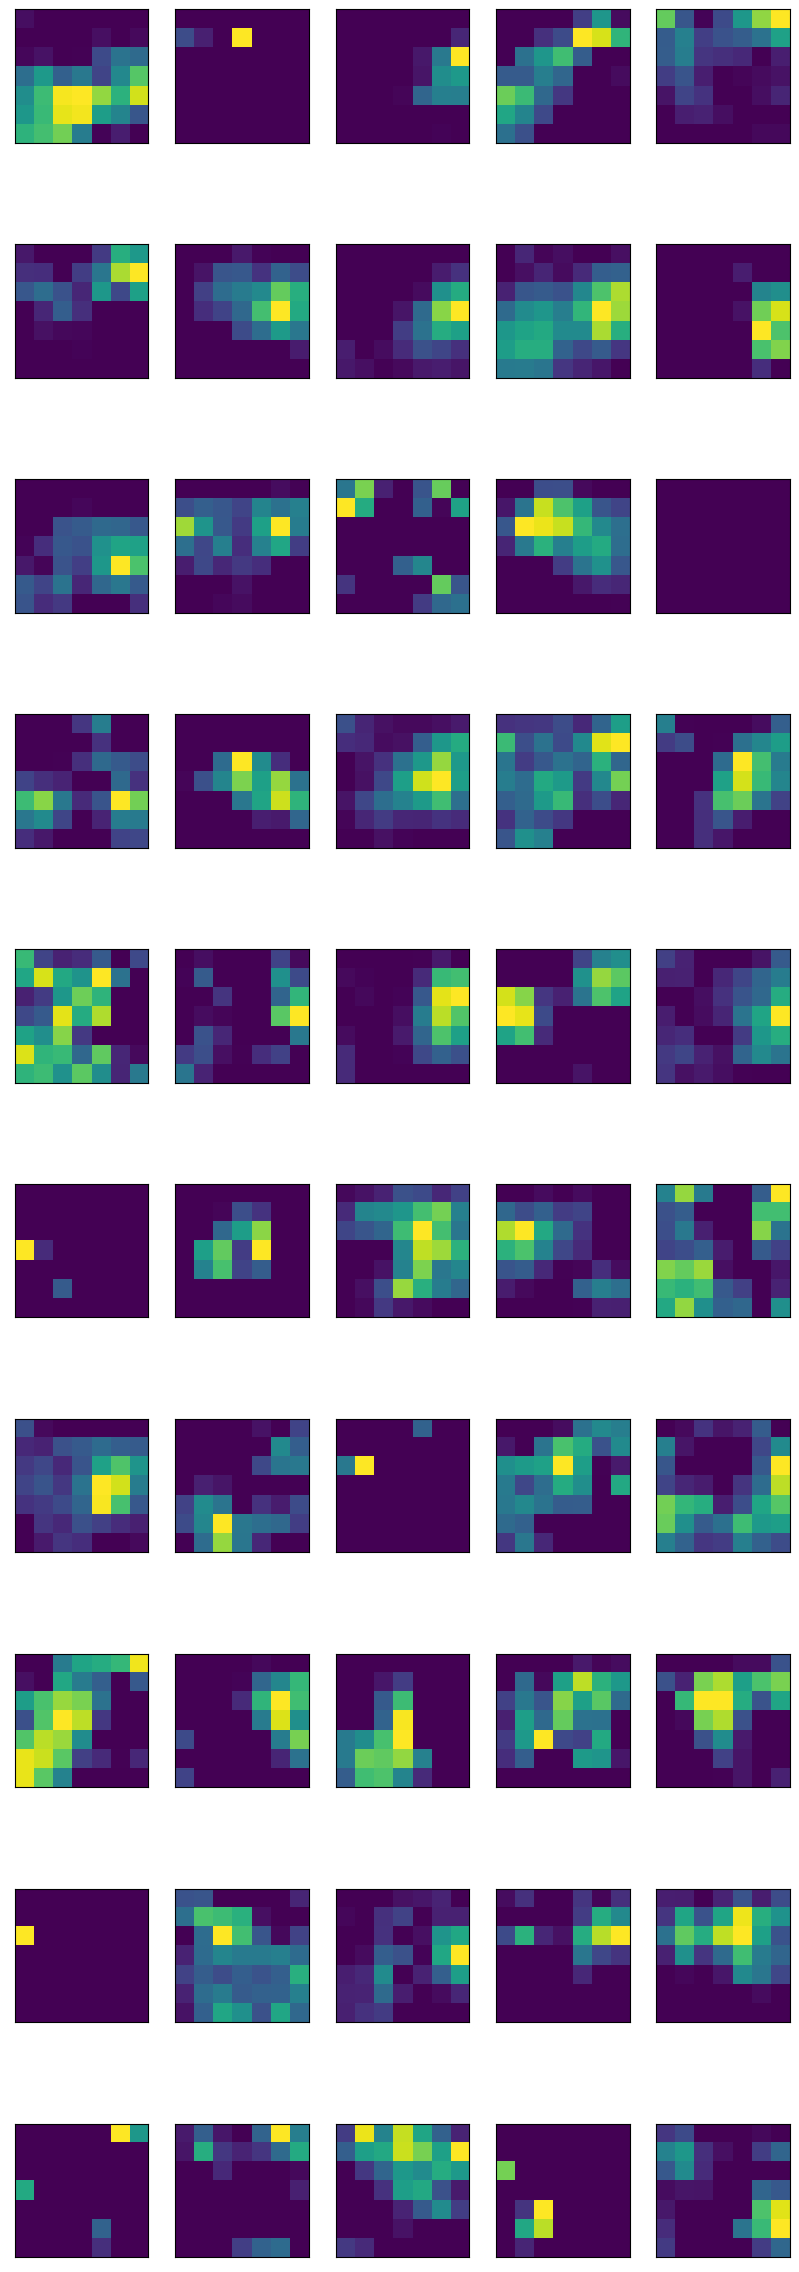

In [24]:
filters = model.encoder.resnet(test_dataset[42][0].unsqueeze(0).to(device))[0, :, :, :].cpu().numpy().transpose((0,1,2))

# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 10, 1
for i in range(n_filters):
    for j in range(5):
        # get the filter
        f = filters[ix-1, :, :]
        ax = plt.subplot(n_filters, 5, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :])
        ix += 1
        
rcParams['figure.figsize'] = 10, 30
plt.show()

In [26]:
train_dog_counter = len(train_data[train_data["caption"].str.contains("[Dd]og")])
test_dog_counter = len(test_data[test_data["caption"].str.contains("[Dd]og")])

In [30]:
print("How many dogs in training data?: ", train_dog_counter)
print("How many dogs in test data?: ", test_dog_counter)
print("percentage of dog in train data: ", train_dog_counter/len(train_data))
print("percentage of dog in test data: ", test_dog_counter/len(test_data))

How many dogs in training data?:  7153
How many dogs in test data?:  1120
percentage of dog in train data:  0.23843333333333333
percentage of dog in test data:  0.224


Every image has exactly 5 captions as reference:

In [31]:
test_dataset.captions[0:6]

0    blond woman in blue shirt appears to wait for ...
1            blond woman is on the street hailing taxi
2    woman is signaling is to traffic as seen from ...
3    woman with blonde hair wearing blue tube top i...
4    the woman in the blue dress is holding out her...
5             boy in his blue swim shorts at the beach
Name: caption, dtype: object

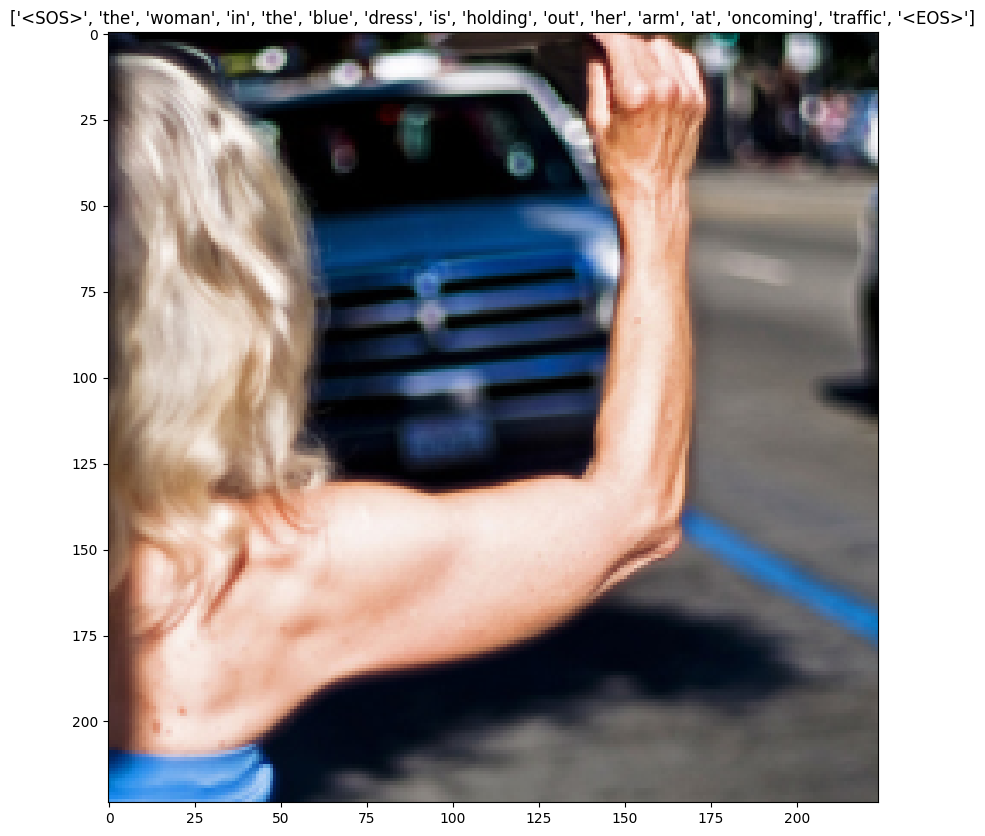

In [32]:
rcParams['figure.figsize'] = 10, 10
show_image(test_dataset[0][0], [test_dataset.vocab.itos[int(i.numpy())] for i in test_dataset[4][1]])

Generate caption for each image in test data:

In [33]:
y_pred = []
y = []
with torch.no_grad():
    for idx in range(0, len(test_dataset), 5):

        #take the image of the 5 reference caption and generate caption
        features = model.encoder(test_dataset[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=test_dataset.vocab)
        y_pred.append(caption[0:-1])
        y_hypotheses = []

        #take all 5 reference captions and store them
        for i in range(idx, idx + 5):
            #print(test_dataset.vocab.itos[int(j.numpy())])
            y_hypotheses.append([test_dataset.vocab.itos[int(j.numpy())] for j in test_dataset[i][1][1:-1]])
        y.append(y_hypotheses)
        if idx % 500 == 0:
            print(f"Done {idx} images")


Done 0 images
Done 500 images
Done 1000 images
Done 1500 images
Done 2000 images
Done 2500 images
Done 3000 images
Done 3500 images
Done 4000 images
Done 4500 images


Generate captions for each dog image:

In [34]:
dog_train_set = train_data[train_data["caption"].str.contains("[Dd]og")].reset_index(drop=True)
dog_test_set = test_data[test_data["caption"].str.contains("[Dd]og")].reset_index(drop=True)

dog_test_dataset = FlickrDataset("../all_images/Flicker8k_Dataset", dog_test_set, transform=toTensor, vocab=vocab)
dog_test_dataloader = DataLoader(dog_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=CapsCollate())

y_pred_dog = []
y_dog = []
y_dog_hypotheses = []
with torch.no_grad():
    for idx in range(0, len(dog_test_set), 5):

        #take the image of the 5 reference caption and generate caption
        features = model.encoder(dog_test_dataset[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=dog_test_dataset.vocab)
        y_pred_dog.append(caption[0:-1])
        y_dog_hypotheses = []

        #take all 5 reference captions and store them
        for i in range(idx, idx + 5):
            #print(test_dataset.vocab.itos[int(j.numpy())])
            y_dog_hypotheses.append([dog_test_dataset.vocab.itos[int(j.numpy())] for j in dog_test_dataset[i][1][1:-1]])
        y_dog.append(y_dog_hypotheses)
        if idx % 500 == 0:
            print(f"Done {idx} images")

Done 0 images
Done 500 images
Done 1000 images


In [35]:
y_train_pred = []
y_train = []
with torch.no_grad():
    for idx in range(0, len(train_dataset), 5):

        #take the image of the 5 reference caption and generate caption
        features = model.encoder(train_dataset[idx][0].unsqueeze(0).to(device))
        caption, alphas = model.decoder.generate_caption(features, 40, vocab=train_dataset.vocab)
        y_train_pred.append(caption[0:-1])
        y_train_hypotheses = []

        #take all 5 reference captions and store them
        for i in range(idx, idx + 5):
            #print(test_dataset.vocab.itos[int(j.numpy())])
            y_train_hypotheses.append([train_dataset.vocab.itos[int(j.numpy())] for j in train_dataset[i][1][1:-1]])
        y_train.append(y_train_hypotheses)
        if idx % 500 == 0:
            print(f"Done {idx} images")


Done 0 images
Done 500 images
Done 1000 images
Done 1500 images
Done 2000 images
Done 2500 images
Done 3000 images
Done 3500 images
Done 4000 images
Done 4500 images
Done 5000 images
Done 5500 images
Done 6000 images
Done 6500 images
Done 7000 images
Done 7500 images
Done 8000 images
Done 8500 images
Done 9000 images
Done 9500 images
Done 10000 images
Done 10500 images
Done 11000 images
Done 11500 images
Done 12000 images
Done 12500 images
Done 13000 images
Done 13500 images
Done 14000 images
Done 14500 images
Done 15000 images
Done 15500 images
Done 16000 images
Done 16500 images
Done 17000 images
Done 17500 images
Done 18000 images
Done 18500 images
Done 19000 images
Done 19500 images
Done 20000 images
Done 20500 images
Done 21000 images
Done 21500 images
Done 22000 images
Done 22500 images
Done 23000 images
Done 23500 images
Done 24000 images
Done 24500 images
Done 25000 images
Done 25500 images
Done 26000 images
Done 26500 images
Done 27000 images
Done 27500 images
Done 28000 image

Samples:

In [36]:
print(y_pred[2])
print(y[2])

['man', 'is', 'sitting', 'on', 'the', 'edge', 'of', 'pool', 'with', 'his', 'shoes', 'in', 'the', 'air']
[['lady', 'and', 'man', 'with', 'no', 'shirt', 'sit', 'on', 'dock'], ['man', 'and', 'woman', 'are', 'sitting', 'on', 'dock', 'together'], ['man', 'and', 'woman', 'sitting', 'on', 'dock'], ['man', 'and', 'woman', 'sitting', 'on', 'deck', 'next', 'to', 'lake'], ['shirtless', 'man', 'and', 'woman', 'sitting', 'on', 'dock']]


## Bleu Scores:

In [37]:
print("references: ", y_dog[0])
print("prediction: ", y_pred_dog[0])
print("bleu: ", sentence_bleu(y[0], y_pred[0], weights=(0, 0, 0, 1)))

references:  [['closeup', 'of', 'white', 'dog', 'that', 'is', 'laying', 'its', 'head', 'on', 'its', 'paws'], ['large', 'white', 'dog', 'lying', 'on', 'the', 'floor'], ['white', 'dog', 'has', 'its', 'head', 'on', 'the', 'ground'], ['white', 'dog', 'is', 'resting', 'its', 'head', 'on', 'tiled', 'floor', 'with', 'its', 'eyes', 'open'], ['white', 'dog', 'rests', 'its', 'head', 'on', 'the', 'patio', 'bricks']]
prediction:  ['white', 'dog', 'is', 'in', 'the', 'snow']
bleu:  2.2250738585072626e-308


c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\bruno\anaconda3\envs\edap5\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

In [ ]:
!python -m spacy download en_core_web_md

In [48]:
import spacy
nlp = spacy.load('en_core_web_md')

train_similarities = 0
for i in range(len(y_train_pred)):
    for j in y_train[i]:
        train_similarities += nlp(' '.join(y_train_pred[i])).similarity(nlp(' '.join(j)))
print(train_similarities/(len(y_train_pred)*5))

similarities = 0
for i in range(len(y_pred)):
    for j in y[i]:
        similarities += nlp(' '.join(y_pred[i])).similarity(nlp(' '.join(j)))
print(similarities/(len(y_pred)*5))

dog_similarities = 0
for i in range(len(y_pred_dog)):
    for j in y_dog[i]:
        dog_similarities += nlp(' '.join(y_pred_dog[i])).similarity(nlp(' '.join(j)))
print(dog_similarities/(len(y_pred_dog)*5))

C:\Users\bruno\AppData\Local\Temp\ipykernel_16580\2368561587.py:7: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  train_similarities += nlp(' '.join(y_train_pred[i])).similarity(nlp(' '.join(j)))


0.7715847640934451
0.6862358970410757
0.7067539194702029


In [39]:
# Define the n-gram weights to use
weights = [(1, 0, 0, 0), (0.5, 0.5, 0, 0), (0.33, 0.33, 0.33, 0), (0.25, 0.25, 0.25, 0.25)]
names = ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"]

# Compute the BLEU scores for each n-gram weight
test_score_all = ["Test Data"]
dog_score_all = ["Only Dogs Test Data"]
train_score_all = ["Train Data"]
concatenated = []
for w in weights:
    score = []
    for i in range(len(y_pred)):
        score.append(sentence_bleu(y[i], y_pred[i], weights=w))
    dog_score = []
    for i in range(len(y_pred_dog)):
        dog_score.append(sentence_bleu(y_dog[i], y_pred_dog[i], weights=w))
    train_score = []
    for i in range(len(y_train_pred)):
        train_score.append(sentence_bleu(y_train[i], y_train_pred[i], weights=w))
    
    test_score_all.append(sum(score)/len(score))
    dog_score_all.append(sum(dog_score)/len(dog_score))
    train_score_all.append(sum(train_score)/len(train_score))

concatenated  = [train_score_all, test_score_all, dog_score_all]
# Generate the LaTeX table with n-grams as column headers
headers = ['Dataset'] + [n for n in names]
table = tabulate(concatenated, headers=headers, tablefmt='pipe', floatfmt='.4f', numalign='center', stralign='center')
print(table)

|       Dataset       |  BLEU-1  |  BLEU-2  |  BLEU-3  |  BLEU-4  |
|:-------------------:|:--------:|:--------:|:--------:|:--------:|
|     Train Data      |  0.8437  |  0.7835  |  0.7440  |  0.7076  |
|      Test Data      |  0.3886  |  0.1656  |  0.0564  |  0.0130  |
| Only Dogs Test Data |  0.4702  |  0.2603  |  0.0977  |  0.0287  |


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

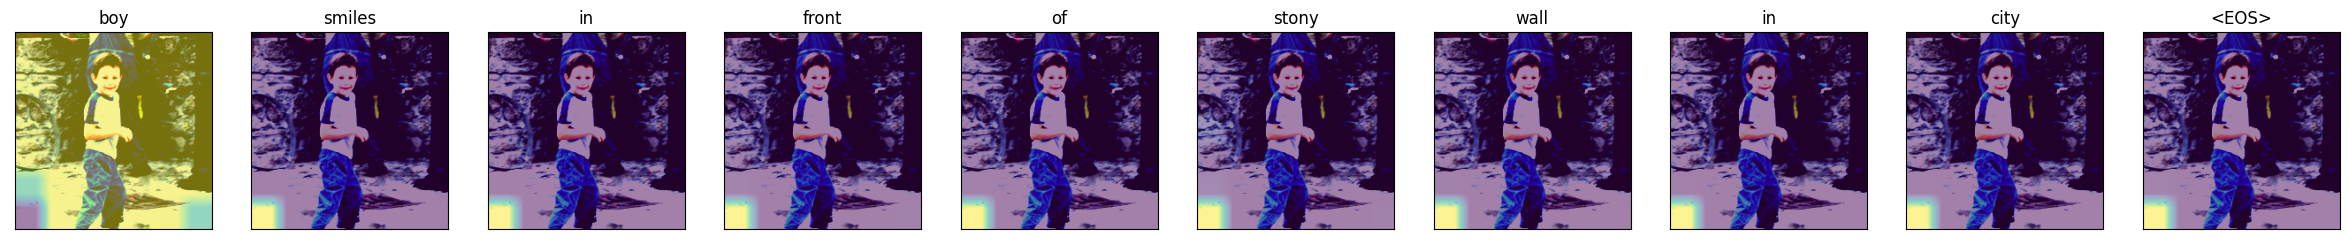

Original Caption:  <SOS> young boy runs aross the street <EOS>


In [42]:
features = model.encoder(train_dataset[42][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=train_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(train_dataset[42][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 50, 40
plt.show()

print("Original Caption: ", " ".join([train_dataset.vocab.itos[int(i.numpy())] for i in train_dataset[42][1]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


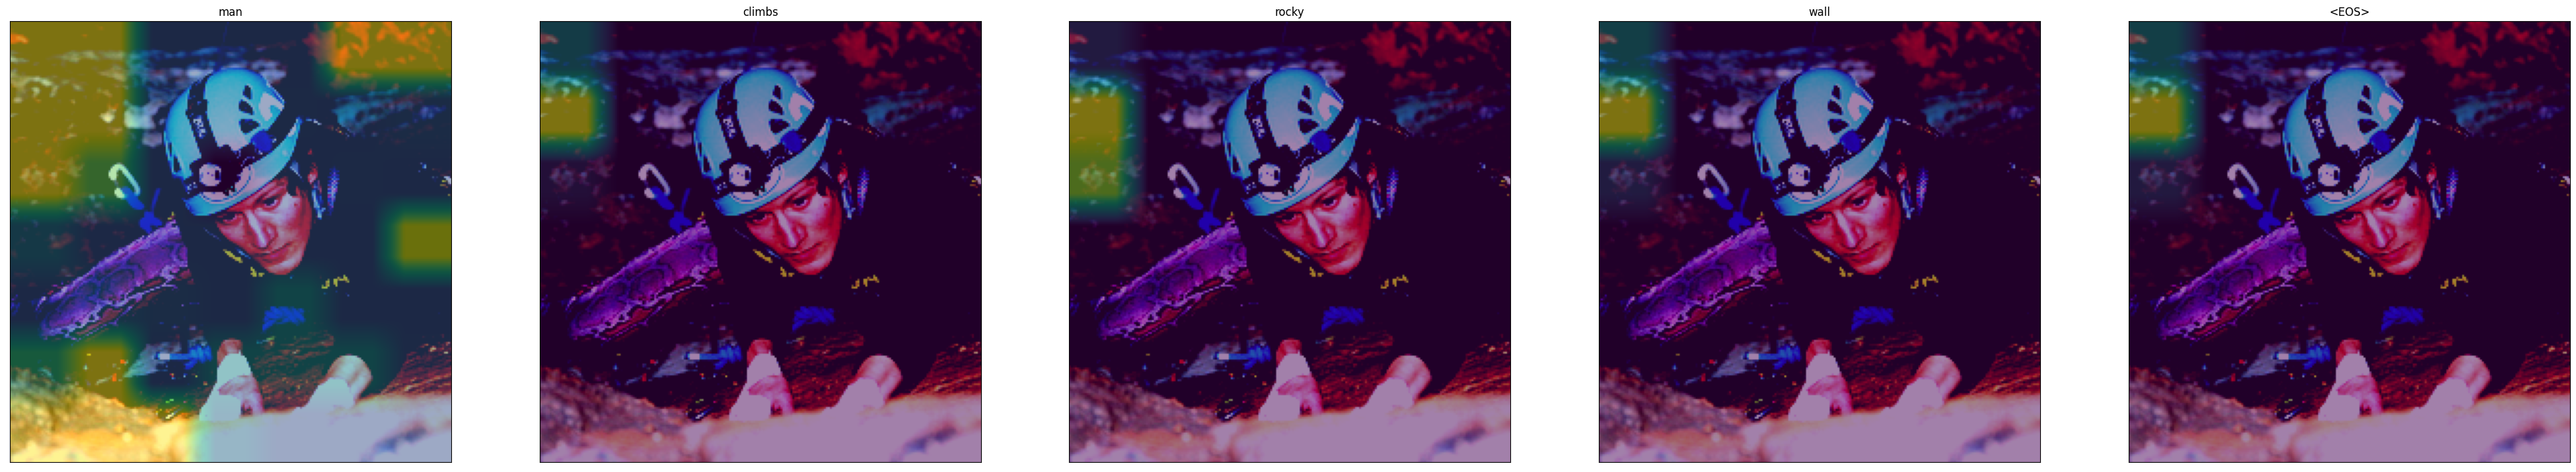

Original Caption:  <SOS> climber wearing blue helmet and headlamp is attached to rope on the rock face <EOS>


In [43]:
features = model.encoder(train_dataset[420][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=train_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(train_dataset[420][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 30, 30
plt.show()

print("Original Caption: ", " ".join([train_dataset.vocab.itos[int(i.numpy())] for i in train_dataset[420][1]]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


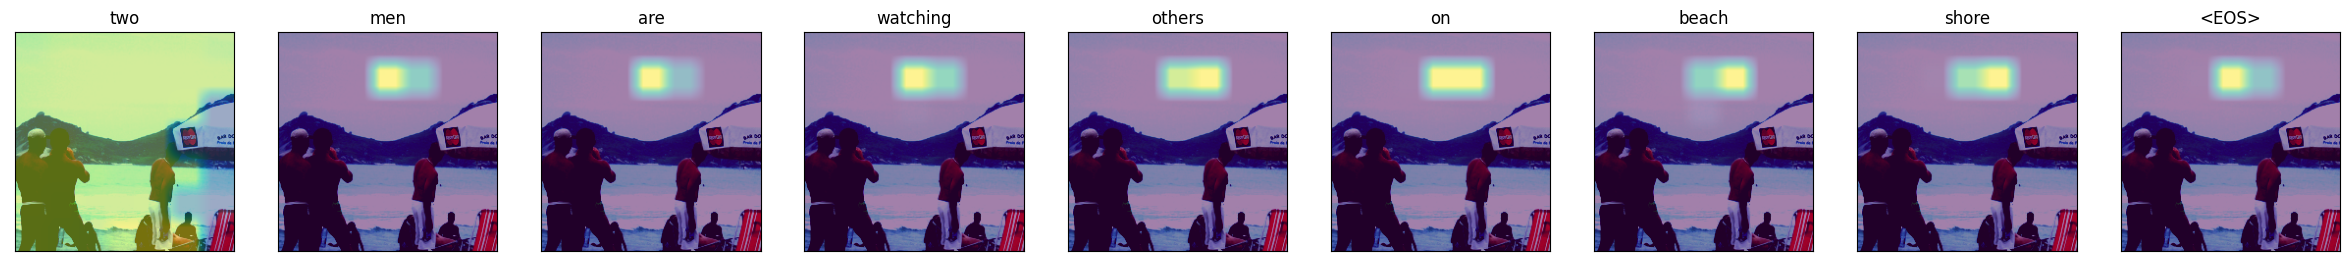

Original Caption:  <SOS> group of people are standing on beach near to white sunshade <EOS>


In [45]:
features = model.encoder(train_dataset[4120][0].unsqueeze(0).to(device))
caption, alphas = model.decoder.generate_caption(features, 40, vocab=train_dataset.vocab)
n_filters, ix = len(alphas), 1
for i in range(len(alphas)):
    f = T.Resize((224,224))(torch.from_numpy(alphas[i].reshape((14, 14))).unsqueeze(0)).squeeze(0)
    ax = plt.subplot(1, n_filters, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(train_dataset[4120][0].numpy().transpose((1,2,0)))
    plt.imshow(f, alpha = 0.5)
    plt.title(caption[i])
    ix += 1

rcParams['figure.figsize'] = 30, 30
plt.show()

print("Original Caption: ", " ".join([train_dataset.vocab.itos[int(i.numpy())] for i in train_dataset[4120][1]]))